In [1]:
from numpy import dtype
from kdg import kdf, kdn, kdcnn
from kdg.utils import get_ece, plot_reliability
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras import activations
from tensorflow.keras import backend as bknd
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os 
import numpy as np
import pickle
import openml
from sklearn.metrics import cohen_kappa_score
from kdg.utils import get_ece
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import random
from itertools import product
import matplotlib.gridspec as gridspec
import matplotlib

In [151]:
def getLeNet(input_shape, num_classes):
    model = keras.Sequential()
    inputs = Input(shape=input_shape)
    x = Conv2D(6, (3,3), kernel_initializer='he_uniform')(inputs)
    x = Activation('relu')(x)
    x = AveragePooling2D()(x)
    x = Conv2D(16, (3,3), kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D((2,2))(x)

    x = Flatten()(x)
    x = Dense(120, kernel_initializer='he_uniform')(x)
    x = Activation('relu')(x)
    x = Dense(84, kernel_initializer='he_uniform')(x)
    x = Activation('relu')(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model
    

In [3]:
### Hyperparameters ###
subtract_pixel_mean = True
normalize = False
classes_to_consider = [[0,1], [2,3],
                       [4,5], [6,7],
                       [8,9]]
seeds = [0,100,200,300,400]

compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 100,
        "batch_size": 32,
        "verbose": False,
        "callbacks": [callback],
    }

In [5]:
### preprocess the data ###

def get_data(classes):
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
    input_shape = x_train.shape[1:]

    train_idx = np.where(y_train==classes[0])[0]
    test_idx = np.where(y_test==classes[0])[0]

    for ii in classes[1:]:
        train_idx = np.concatenate((
                        train_idx,
                        np.where(y_train==ii)[0]
                    ))
        test_idx = np.concatenate((
                        test_idx,
                        np.where(y_test==ii)[0]
                    ))

    x_train, y_train = x_train[train_idx], y_train[train_idx]
    x_test, y_test = x_test[test_idx], y_test[test_idx]
    
    _, y_train = np.unique(y_train, return_inverse=True)
    _, y_test = np.unique(y_test, return_inverse=True)
    
    if normalize:
        x_train = x_train.astype('float32') / 255
        x_test = x_test.astype('float32') / 255
    else:
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
    
    x_train_mean = np.mean(x_train, axis=0)
    if subtract_pixel_mean:
        x_train -= x_train_mean
        x_test -= x_train_mean
    return (x_train, y_train), (x_test, y_test), x_train_mean

In [155]:
### train LeNet5 ###

for task, classes in enumerate(classes_to_consider):
    (x_train, y_train), (x_test, y_test), _ = get_data(classes)
    input_shape = x_train[0].shape
    for seed in seeds:
        np.random.seed(seed)
        nn = getLeNet(input_shape, num_classes=len(np.unique(y_train)))
        nn.compile(**compile_kwargs)
        history = nn.fit(x_train, keras.utils.to_categorical(y_train), **fit_kwargs)
        
        y_pred = np.argmax(nn.predict(x_test), axis=1)
        print('Trained model with classes ', classes, ' seed ', seed)
        print('Accuracy:', np.mean(y_pred==y_test.reshape(-1)))
        nn.save('lenet_models/cifar10_model_'+str(task)+'_'+str(seed))

2023-08-05 12:21:13.939056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 49: early stopping
63/63 [==============================] - 0s 3ms/step


2023-08-05 12:23:00.764011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Trained model with classes  [0, 1]  seed  0
Accuracy: 0.909


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_0_0/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_0_0/assets
2023-08-05 12:23:01.569966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 51: early stopping
63/63 [==============================] - 0s 2ms/step


2023-08-05 12:24:51.946076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Trained model with classes  [0, 1]  seed  100
Accuracy: 0.9115


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_0_100/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_0_100/assets
2023-08-05 12:24:52.755993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 44: early stopping
63/63 [==============================] - 0s 2ms/step


2023-08-05 12:26:28.678642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Trained model with classes  [0, 1]  seed  200
Accuracy: 0.912


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_0_200/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_0_200/assets
2023-08-05 12:26:29.517766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 45: early stopping
63/63 [==============================] - 0s 3ms/step


2023-08-05 12:28:07.340798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Trained model with classes  [0, 1]  seed  300
Accuracy: 0.9305


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_0_300/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_0_300/assets
2023-08-05 12:28:08.155446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 52: early stopping
48/63 [=====================>........] - ETA: 0s

2023-08-05 12:30:00.136199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [0, 1]  seed  400
Accuracy: 0.918


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_0_400/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_0_400/assets
2023-08-05 12:30:01.524509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 77: early stopping
63/63 [==============================] - 0s 3ms/step


2023-08-05 12:32:48.562442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Trained model with classes  [2, 3]  seed  0
Accuracy: 0.7655


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_1_0/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_1_0/assets
2023-08-05 12:32:49.373073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 50: early stopping
63/63 [==============================] - 0s 2ms/step


2023-08-05 12:34:36.587178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Trained model with classes  [2, 3]  seed  100
Accuracy: 0.7535


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_1_100/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_1_100/assets
2023-08-05 12:34:37.390326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 79: early stopping
48/63 [=====================>........] - ETA: 0s

2023-08-05 12:37:26.226391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [2, 3]  seed  200
Accuracy: 0.773


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_1_200/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_1_200/assets
2023-08-05 12:37:27.052116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 76: early stopping
45/63 [====================>.........] - ETA: 0s

2023-08-05 12:40:10.938318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [2, 3]  seed  300
Accuracy: 0.771


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_1_300/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_1_300/assets
2023-08-05 12:40:11.764931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/63 [====================>.........] - ETA: 0s

2023-08-05 12:43:47.703348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [2, 3]  seed  400
Accuracy: 0.7695


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_1_400/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_1_400/assets
2023-08-05 12:43:48.728484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 64: early stopping
63/63 [==============================] - 0s 3ms/step


2023-08-05 12:46:05.957367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Trained model with classes  [4, 5]  seed  0
Accuracy: 0.817


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_2_0/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_2_0/assets
2023-08-05 12:46:06.765237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 53: early stopping
48/63 [=====================>........] - ETA: 0s

2023-08-05 12:48:00.659799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [4, 5]  seed  100
Accuracy: 0.8275


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_2_100/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_2_100/assets
2023-08-05 12:48:01.901820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 65: early stopping
63/63 [==============================] - 0s 3ms/step


2023-08-05 12:50:21.680550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Trained model with classes  [4, 5]  seed  200
Accuracy: 0.819


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_2_200/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_2_200/assets
2023-08-05 12:50:22.490972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 94: early stopping
63/63 [==============================] - 0s 3ms/step


2023-08-05 12:53:44.519108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Trained model with classes  [4, 5]  seed  300
Accuracy: 0.834


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_2_300/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_2_300/assets
2023-08-05 12:53:45.337210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 65: early stopping
63/63 [==============================] - 0s 3ms/step


2023-08-05 12:56:07.404420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Trained model with classes  [4, 5]  seed  400
Accuracy: 0.824


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_2_400/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_2_400/assets
2023-08-05 12:56:08.421230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping
46/63 [====================>.........] - ETA: 0s

2023-08-05 12:57:32.174482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [6, 7]  seed  0
Accuracy: 0.917


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_3_0/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_3_0/assets
2023-08-05 12:57:33.015957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 43: early stopping
50/63 [======================>.......] - ETA: 0s

2023-08-05 12:59:03.968390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 2ms/step
Trained model with classes  [6, 7]  seed  100
Accuracy: 0.921


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_3_100/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_3_100/assets
2023-08-05 12:59:04.769750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 58: early stopping
49/63 [======================>.......] - ETA: 0s

2023-08-05 13:01:00.075867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [6, 7]  seed  200
Accuracy: 0.925


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_3_200/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_3_200/assets
2023-08-05 13:01:01.231815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 73: early stopping
47/63 [=====================>........] - ETA: 0s

2023-08-05 13:03:26.560438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [6, 7]  seed  300
Accuracy: 0.914


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_3_300/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_3_300/assets
2023-08-05 13:03:27.357575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 51: early stopping
49/63 [======================>.......] - ETA: 0s

2023-08-05 13:05:09.236327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [6, 7]  seed  400
Accuracy: 0.919


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_3_400/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_3_400/assets
2023-08-05 13:05:10.232054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 54: early stopping
53/63 [========================>.....] - ETA: 0s

2023-08-05 13:06:57.735090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [8, 9]  seed  0
Accuracy: 0.9075


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_4_0/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_4_0/assets
2023-08-05 13:06:58.526754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 71: early stopping
49/63 [======================>.......] - ETA: 0s

2023-08-05 13:09:19.545743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [8, 9]  seed  100
Accuracy: 0.891


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_4_100/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_4_100/assets
2023-08-05 13:09:20.343165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 67: early stopping
48/63 [=====================>........] - ETA: 0s

2023-08-05 13:11:34.103427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [8, 9]  seed  200
Accuracy: 0.8935


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_4_200/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_4_200/assets
2023-08-05 13:11:34.916583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 77: early stopping
49/63 [======================>.......] - ETA: 0s

2023-08-05 13:14:07.706933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [8, 9]  seed  300
Accuracy: 0.91


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_4_300/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_4_300/assets
2023-08-05 13:14:08.511720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 59: early stopping
49/63 [======================>.......] - ETA: 0s

2023-08-05 13:16:05.557825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Trained model with classes  [8, 9]  seed  400
Accuracy: 0.901


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_4_400/assets


INFO:tensorflow:Assets written to: lenet_models/cifar10_model_4_400/assets


In [156]:
### load models and train kgn ###
for task, classes in enumerate(classes_to_consider):
    (x_train, y_train), (x_test, y_test), _ = get_data(classes)
    for seed in seeds:
        print('Training cifar10_model_'+str(task)+'_'+str(seed))
        nn = keras.models.load_model('lenet_models/cifar10_model_'+str(task)+'_'+str(seed))
        model_kdn = kdn(network=nn)
        model_kdn.fit(x_train, y_train, batch=10)
        model_kdn.global_bias = -1e7
        
        with open('kdn_models/cifar10_model_'+str(task)+'_'+str(seed)+'.pickle', 'wb') as f:
            pickle.dump(model_kdn, f)

Training cifar10_model_0_0


INFO:tensorflow:Assets written to: ram://27f7c601-963c-4753-874b-f792cb6880c6/assets


INFO:tensorflow:Assets written to: ram://27f7c601-963c-4753-874b-f792cb6880c6/assets


Training cifar10_model_0_100


INFO:tensorflow:Assets written to: ram://dec1be89-0665-42cf-9907-7c7fd7f46cbc/assets


INFO:tensorflow:Assets written to: ram://dec1be89-0665-42cf-9907-7c7fd7f46cbc/assets


Training cifar10_model_0_200


INFO:tensorflow:Assets written to: ram://96453b34-e7ff-470b-ad88-5f020eef3fca/assets


INFO:tensorflow:Assets written to: ram://96453b34-e7ff-470b-ad88-5f020eef3fca/assets


Training cifar10_model_0_300


INFO:tensorflow:Assets written to: ram://25ace94e-74e9-4a41-a9df-5cb3e0d05ad9/assets


INFO:tensorflow:Assets written to: ram://25ace94e-74e9-4a41-a9df-5cb3e0d05ad9/assets


Training cifar10_model_0_400


INFO:tensorflow:Assets written to: ram://8e83da3b-cf73-4927-a74a-19c1763aa1f2/assets


INFO:tensorflow:Assets written to: ram://8e83da3b-cf73-4927-a74a-19c1763aa1f2/assets


Training cifar10_model_1_0


INFO:tensorflow:Assets written to: ram://33db1ccb-93ed-4866-9825-c359c53d9204/assets


INFO:tensorflow:Assets written to: ram://33db1ccb-93ed-4866-9825-c359c53d9204/assets


Training cifar10_model_1_100


INFO:tensorflow:Assets written to: ram://2f5e079c-9253-4369-aa7a-d4c991e9e740/assets


INFO:tensorflow:Assets written to: ram://2f5e079c-9253-4369-aa7a-d4c991e9e740/assets


Training cifar10_model_1_200


INFO:tensorflow:Assets written to: ram://02a3f1a4-bcba-4c37-a9e7-b068480337c2/assets


INFO:tensorflow:Assets written to: ram://02a3f1a4-bcba-4c37-a9e7-b068480337c2/assets


Training cifar10_model_1_300


INFO:tensorflow:Assets written to: ram://ab7e55c5-84a7-4440-b5d2-015f6a90ccdf/assets


INFO:tensorflow:Assets written to: ram://ab7e55c5-84a7-4440-b5d2-015f6a90ccdf/assets


Training cifar10_model_1_400


INFO:tensorflow:Assets written to: ram://5a3bd5cd-7117-4482-be20-f18df0ce3587/assets


INFO:tensorflow:Assets written to: ram://5a3bd5cd-7117-4482-be20-f18df0ce3587/assets


Training cifar10_model_2_0


INFO:tensorflow:Assets written to: ram://7ba1bf62-0de7-4f3b-8568-5df538f6e5fd/assets


INFO:tensorflow:Assets written to: ram://7ba1bf62-0de7-4f3b-8568-5df538f6e5fd/assets


Training cifar10_model_2_100


INFO:tensorflow:Assets written to: ram://973cc294-7a5c-4322-9f0e-f1d227a4dc0a/assets


INFO:tensorflow:Assets written to: ram://973cc294-7a5c-4322-9f0e-f1d227a4dc0a/assets


Training cifar10_model_2_200


INFO:tensorflow:Assets written to: ram://a16fa23e-1585-4ba3-b842-07d4be41b23b/assets


INFO:tensorflow:Assets written to: ram://a16fa23e-1585-4ba3-b842-07d4be41b23b/assets


Training cifar10_model_2_300


INFO:tensorflow:Assets written to: ram://74f14642-6974-4697-8232-65fa77a2c0e4/assets


INFO:tensorflow:Assets written to: ram://74f14642-6974-4697-8232-65fa77a2c0e4/assets


Training cifar10_model_2_400


INFO:tensorflow:Assets written to: ram://14a4201f-610a-4410-a32c-56e303109a16/assets


INFO:tensorflow:Assets written to: ram://14a4201f-610a-4410-a32c-56e303109a16/assets


Training cifar10_model_3_0


INFO:tensorflow:Assets written to: ram://faf02df4-c8ae-4e02-9a0e-55412bdaf12d/assets


INFO:tensorflow:Assets written to: ram://faf02df4-c8ae-4e02-9a0e-55412bdaf12d/assets


Training cifar10_model_3_100


INFO:tensorflow:Assets written to: ram://c9818a6f-5bbf-4f66-ad94-5ca1d383baeb/assets


INFO:tensorflow:Assets written to: ram://c9818a6f-5bbf-4f66-ad94-5ca1d383baeb/assets


Training cifar10_model_3_200


INFO:tensorflow:Assets written to: ram://92e6ab8e-47c3-4115-9c18-113fed0670e7/assets


INFO:tensorflow:Assets written to: ram://92e6ab8e-47c3-4115-9c18-113fed0670e7/assets


Training cifar10_model_3_300


INFO:tensorflow:Assets written to: ram://26021851-62a8-4528-a84f-d913f8a07b1f/assets


INFO:tensorflow:Assets written to: ram://26021851-62a8-4528-a84f-d913f8a07b1f/assets


Training cifar10_model_3_400


INFO:tensorflow:Assets written to: ram://c7eaee21-c6a6-4854-abe2-cb03a43eba61/assets


INFO:tensorflow:Assets written to: ram://c7eaee21-c6a6-4854-abe2-cb03a43eba61/assets


Training cifar10_model_4_0


INFO:tensorflow:Assets written to: ram://87ec9631-e4d2-465b-a59a-898845a097a1/assets


INFO:tensorflow:Assets written to: ram://87ec9631-e4d2-465b-a59a-898845a097a1/assets


Training cifar10_model_4_100


INFO:tensorflow:Assets written to: ram://5d3f5afe-b54f-4190-8e22-1cfbfe7ab456/assets


INFO:tensorflow:Assets written to: ram://5d3f5afe-b54f-4190-8e22-1cfbfe7ab456/assets


Training cifar10_model_4_200


INFO:tensorflow:Assets written to: ram://e70a6457-2d65-4670-94e9-de18daff777a/assets


INFO:tensorflow:Assets written to: ram://e70a6457-2d65-4670-94e9-de18daff777a/assets


Training cifar10_model_4_300


INFO:tensorflow:Assets written to: ram://1c58355c-0dd6-4d69-921f-af54eda051ef/assets


INFO:tensorflow:Assets written to: ram://1c58355c-0dd6-4d69-921f-af54eda051ef/assets


Training cifar10_model_4_400


INFO:tensorflow:Assets written to: ram://f7937c33-4c3a-4de4-bd87-2f0998185111/assets


INFO:tensorflow:Assets written to: ram://f7937c33-4c3a-4de4-bd87-2f0998185111/assets


In [290]:
subtract_pixel_mean = False
normalize = False

for task, classes in enumerate(classes_to_consider):        
    for seed in seeds:
        print('Testing cifar10_model_'+str(task)+'_'+str(seed))
        
        np.random.seed(seed)
        result = []
        proba_kdn = {}
        proba_dn = {}
        predicted_label_kdn = {}
        predicted_label_dn = {}
        
        (_, _), (_, _), train_mean = get_data(classes)
        with open('kdn_models/cifar10_model_'+str(task)+'_'+str(seed)+'.pickle', 'rb') as f:
            model_kdn = pickle.load(f)
            
        for task_, classes_ in enumerate(classes_to_consider):         
            (_, _), (x_test, y_test), _ = get_data(classes_)
            x_test -= trn_mean
            
            proba_kdn['Task '+str(task_)] = model_kdn.predict_proba(x_test, distance='Geodesic')
            proba_dn['Task '+str(task_)] = model_kdn.network.predict(x_test)
            predicted_label_kdn['Task '+str(task_)] = np.argmax(proba_kdn['Task '+str(task_)], axis = 1)
            predicted_label_dn['Task '+str(task_)] = np.argmax(proba_dn['Task '+str(task_)], axis = 1)
            print('Task ', task_, ' MMC ', np.mean(np.max(proba_kdn['Task '+str(task_)], axis=1)))
            print('Task ', task_, ' MMC ', np.mean(np.max(proba_dn['Task '+str(task_)], axis=1)))
        
        model_kdn.global_bias = -1e7
        (_, _), (x_test, y_test) = keras.datasets.cifar100.load_data()
        test_ids =  random.sample(range(0, x_test.shape[0]), 2000)
        x_test = x_test[test_ids].astype('float32')
        x_test -= trn_mean
        proba_kdn['cifar100'] = model_kdn.predict_proba(x_test, distance='Geodesic')
        proba_dn['cifar100'] = model_kdn.network.predict(x_test)
        predicted_label_kdn['cifar100'] = np.argmax(proba_kdn['cifar100'], axis = 1)
        predicted_label_dn['cifar100'] = np.argmax(proba_dn['cifar100'], axis = 1)
        print('cifar100', ' MMC ', np.mean(np.max(proba_kdn['cifar100'], axis=1)))
        print('cifar100', ' MMC ', np.mean(np.max(proba_dn['cifar100'], axis=1)))
        
        x_test = loadmat('/Users/jayantadey/svhn/train_32x32.mat')['X']
        test_ids =  random.sample(range(0, x_test.shape[3]), 2000)
        x_test = x_test[:,:,:,test_ids].astype('float32').reshape(2000,32,32,3)
        x_test -= trn_mean
        proba_kdn['svhn'] = model_kdn.predict_proba(x_test, distance='Geodesic')
        proba_dn['svhn'] = model_kdn.network.predict(x_test)
        predicted_label_kdn['svhn'] = np.argmax(proba_kdn['svhn'], axis = 1)
        predicted_label_dn['svhn'] = np.argmax(proba_dn['svhn'], axis = 1)
        print('svhn', ' MMC ', np.mean(np.max(proba_kdn['svhn'], axis=1)))
        print('svhn', ' MMC ', np.mean(np.max(proba_dn['svhn'], axis=1)))
        
        x_test = np.random.random_integers(0,high=255,size=(2000,32,32,3)).astype('float')
        x_test -= trn_mean
        proba_kdn['noise'] = model_kdn.predict_proba(x_test, distance='Geodesic')
        proba_dn['noise'] = model_kdn.network.predict(x_test)
        predicted_label_kdn['noise'] = np.argmax(proba_kdn['noise'], axis = 1)
        predicted_label_dn['noise'] = np.argmax(proba_dn['noise'], axis = 1)
        print('noise', ' MMC ', np.mean(np.max(proba_kdn['noise'], axis=1)))
        print('noise', ' MMC ', np.mean(np.max(proba_dn['noise'], axis=1)))
        
        result = [proba_kdn, proba_dn, predicted_label_kdn, predicted_label_dn]
        with open('results/model_'+str(task)+'_'+str(seed)+'.pickle', 'wb') as f:
            pickle.dump(result, f)

Testing cifar10_model_4_0
45/63 [====================>.........] - ETA: 0s

2023-08-06 21:03:00.344907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.63425
Task  0  MMC  0.984582
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.5855
Task  1  MMC  0.98345083
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.57175
Task  2  MMC  0.98090553
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.5565
Task  3  MMC  0.9857606
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  1.0
Task  4  MMC  0.99165344
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.5925
cifar100  MMC  0.98549473
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.5
svhn  MMC  1.0
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.5
noise  MMC  1.0
Testing cifar10_model_4_100
43/63 [===================>..........] - ETA: 0s

2023-08-06 21:32:58.895581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.6234999994304435
Task  0  MMC  0.9842139
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.566999999385814
Task  1  MMC  0.9761731
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.5572499997636845
Task  2  MMC  0.9763956
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.5259999995310711
Task  3  MMC  0.9861787
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  0.9987496965325479
Task  4  MMC  0.98900294
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.5747499984063565
cifar100  MMC  0.9817464
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.5
svhn  MMC  0.99998266
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.5
noise  MMC  0.99999785
Testing cifar10_model_4_200
47/63 [=====================>........] - ETA: 0s

2023-08-06 22:02:58.991578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.6157499957714458
Task  0  MMC  0.9818019
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.5509999890359346
Task  1  MMC  0.98014814
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.5357499944042577
Task  2  MMC  0.9787869
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.5172499889101186
Task  3  MMC  0.9811169
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  0.9964999778742357
Task  4  MMC  0.98894745
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.5632499903945133
cifar100  MMC  0.98223597
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.5
svhn  MMC  1.0
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.5
noise  MMC  1.0
Testing cifar10_model_4_300
46/63 [====================>.........] - ETA: 0s

2023-08-06 22:33:00.825562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.6102499822160667
Task  0  MMC  0.9863655
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.544249992099514
Task  1  MMC  0.9808528
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.5234999943706931
Task  2  MMC  0.9807631
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.5117499999501675
Task  3  MMC  0.98480844
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  0.9992499953289462
Task  4  MMC  0.9918025
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.5484999901989499
cifar100  MMC  0.98246616
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.5
svhn  MMC  1.0
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.5
noise  MMC  1.0
Testing cifar10_model_4_400
44/63 [===================>..........] - ETA: 0s

2023-08-06 23:03:13.233433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 3ms/step
Task  0  MMC  0.6102499963465271
Task  0  MMC  0.98233944
63/63 [==============================] - 0s 2ms/step
Task  1  MMC  0.5517499935319189
Task  1  MMC  0.9756949
63/63 [==============================] - 0s 2ms/step
Task  2  MMC  0.5357499977950623
Task  2  MMC  0.97922254
63/63 [==============================] - 0s 2ms/step
Task  3  MMC  0.5184999896977447
Task  3  MMC  0.9867698
63/63 [==============================] - 0s 2ms/step
Task  4  MMC  0.9989999425713275
Task  4  MMC  0.989826
63/63 [==============================] - 0s 2ms/step
cifar100  MMC  0.5579999906746194
cifar100  MMC  0.98161453
63/63 [==============================] - 0s 2ms/step
svhn  MMC  0.5
svhn  MMC  1.0
63/63 [==============================] - 0s 2ms/step
noise  MMC  0.5
noise  MMC  1.0


In [7]:
MMC_benchmark = {}
MMC_kdn = {}
MMC_dn = {}
MMC_kdn_euclidean = {}
accuracy = {}
accuracy_all = []
algorithm = []
train_task = []

datasets = ['Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5', 'CIFAR100', 'SVHN', 'Noise']
for task, classes in enumerate(classes_to_consider): 
    mmc_kdn = np.zeros(len(datasets), dtype=float)
    mmc_kdn_euclidean = np.zeros(len(datasets), dtype=float)
    mmc_dn = np.zeros(len(datasets), dtype=float)
    mmc_benchmark = np.zeros(len(datasets), dtype=float)
    
    (_, _), (x_test, y_test), _ = get_data(classes)
    for seed in seeds:
        with open('results/model_'+str(task)+'_'+str(seed)+'.pickle', 'rb') as f:
            result = pickle.load(f)
        
        with open('results/model_euclidean_'+str(task)+'_'+str(seed)+'.pickle', 'rb') as f:
            result_ = pickle.load(f)
        
        with open('results/ACET_'+str(task)+'_'+str(seed)+'.pickle', 'rb') as f:
            df_ben, acc_ben = pickle.load(f)
            
        for ii, key in enumerate(result[0].keys()):
            mmc_kdn[ii] += np.mean(np.max(result[0][key], axis=1))
            mmc_dn[ii] += np.mean(np.max(result[1][key], axis=1))
            mmc_kdn_euclidean[ii] += np.mean(np.max(result_[0][key], axis=1))
        
        for ii, key in enumerate(df_ben.keys()):
            mmc_benchmark[ii] += df_ben[key]
        
        accuracy_all.append(np.mean(result_[1]['Task '+str(task)]==y_test.reshape(-1))) 
        algorithm.append('KDN-Euclidean')
        train_task.append('Task '+str(task+1))
        
        accuracy_all.append(np.mean(result[2]['Task '+str(task)]==y_test.reshape(-1)))
        algorithm.append('KDN-Geodesic')
        train_task.append('Task '+str(task+1))
        
        accuracy_all.append(acc_ben)
        algorithm.append('ACET')
        train_task.append('Task '+str(task+1))
        
        accuracy_all.append(np.mean(result[3]['Task '+str(task)]==y_test.reshape(-1)))
        algorithm.append('LeNet-5')
        train_task.append('Task '+str(task+1))
        
    mmc_kdn /= 5
    mmc_kdn_euclidean /= 5
    mmc_benchmark /= 5
    mmc_dn /= 5
    
    MMC_kdn['Task '+str(task+1)] = mmc_kdn
    MMC_kdn_euclidean['Task '+str(task+1)] = mmc_kdn_euclidean
    MMC_benchmark['Task '+str(task+1)] = mmc_benchmark
    MMC_dn['Task '+str(task+1)] = mmc_dn
    
accuracy['Accuracy'] = accuracy_all
accuracy['Algorithm'] = algorithm
accuracy['Dataset to Train on'] = train_task

In [8]:
kdn_df = pd.DataFrame(MMC_kdn)
kdn_df.index = datasets

kdn_euclidean_df = pd.DataFrame(MMC_kdn_euclidean)
kdn_euclidean_df.index = datasets

dn_df = pd.DataFrame(MMC_dn)
dn_df.index = datasets

benchmark_df = pd.DataFrame(MMC_benchmark)
dn_df.index = datasets

accuracy_df = pd.DataFrame(accuracy)

In [9]:
kdn_df

,Task 1,Task 2,Task 3,Task 4,Task 5
Task 1,0.998883,0.614899,0.57275,0.58780,0.6188
Task 2,0.660362,0.998800,0.59015,0.59245,0.5599
Task 3,0.637825,0.604350,0.99845,0.57400,0.5448
Task 4,0.611900,0.586500,0.55970,0.99835,0.5260
Task 5,0.616370,0.557300,0.54410,0.54770,0.9987
CIFAR100,0.658914,0.609900,0.58265,0.58440,0.5674
SVHN,0.503050,0.529400,0.50185,0.52515,0.5000
Noise,0.501999,0.501750,0.50005,0.50015,0.5000


In [10]:
benchmark_df

,Task 1,Task 2,Task 3,Task 4,Task 5
0,0.945361,0.910482,0.925325,0.958037,0.938029
1,0.945361,0.910482,0.925325,0.958037,0.938029
2,0.945361,0.910482,0.925325,0.958037,0.938029
3,0.945361,0.910482,0.925325,0.958037,0.938029
4,0.945361,0.910482,0.925325,0.958037,0.938029
5,0.893005,0.893218,0.897412,0.920648,0.917340
6,0.895950,0.833578,0.728892,0.749307,0.857250
7,0.969327,0.998606,0.999161,0.999766,0.997607


In [11]:
kdn_euclidean_df

,Task 1,Task 2,Task 3,Task 4,Task 5
Task 1,0.998841,0.61650,0.59170,0.60600,0.68185
Task 2,0.751911,0.99795,0.62210,0.61065,0.63185
Task 3,0.725919,0.61610,0.99780,0.59985,0.62050
Task 4,0.702520,0.61390,0.59835,0.99765,0.59130
Task 5,0.693507,0.55785,0.55785,0.54915,0.99775
CIFAR100,0.733584,0.61590,0.60845,0.60890,0.62680
SVHN,0.999981,0.66245,0.81235,0.50000,0.53140
Noise,0.999681,0.50005,0.50000,0.50000,0.52850


In [12]:
dn_df

,Task 1,Task 2,Task 3,Task 4,Task 5
Task 1,0.991756,0.976130,0.980779,0.975377,0.983861
Task 2,0.979967,0.981869,0.982061,0.979643,0.979264
Task 3,0.979402,0.978815,0.985580,0.980762,0.979215
Task 4,0.973622,0.975676,0.979133,0.990204,0.984927
Task 5,0.980502,0.974796,0.979777,0.976899,0.990246
CIFAR100,0.978802,0.976939,0.982110,0.979538,0.982712
SVHN,0.994126,0.975993,0.928464,0.972423,0.999997
Noise,0.996259,0.984051,0.974917,0.965575,1.000000


In [13]:
accuracy_df

,Accuracy,Algorithm,Dataset to Train on
0,0.5160,KDN-Euclidean,Task 1
1,0.8540,KDN-Geodesic,Task 1
2,0.8685,ACET,Task 1
3,0.9090,LeNet-5,Task 1
4,0.7145,KDN-Euclidean,Task 1
...,...,...,...
95,0.9135,LeNet-5,Task 5
96,0.6990,KDN-Euclidean,Task 5
97,0.9045,KDN-Geodesic,Task 5
98,0.8565,ACET,Task 5


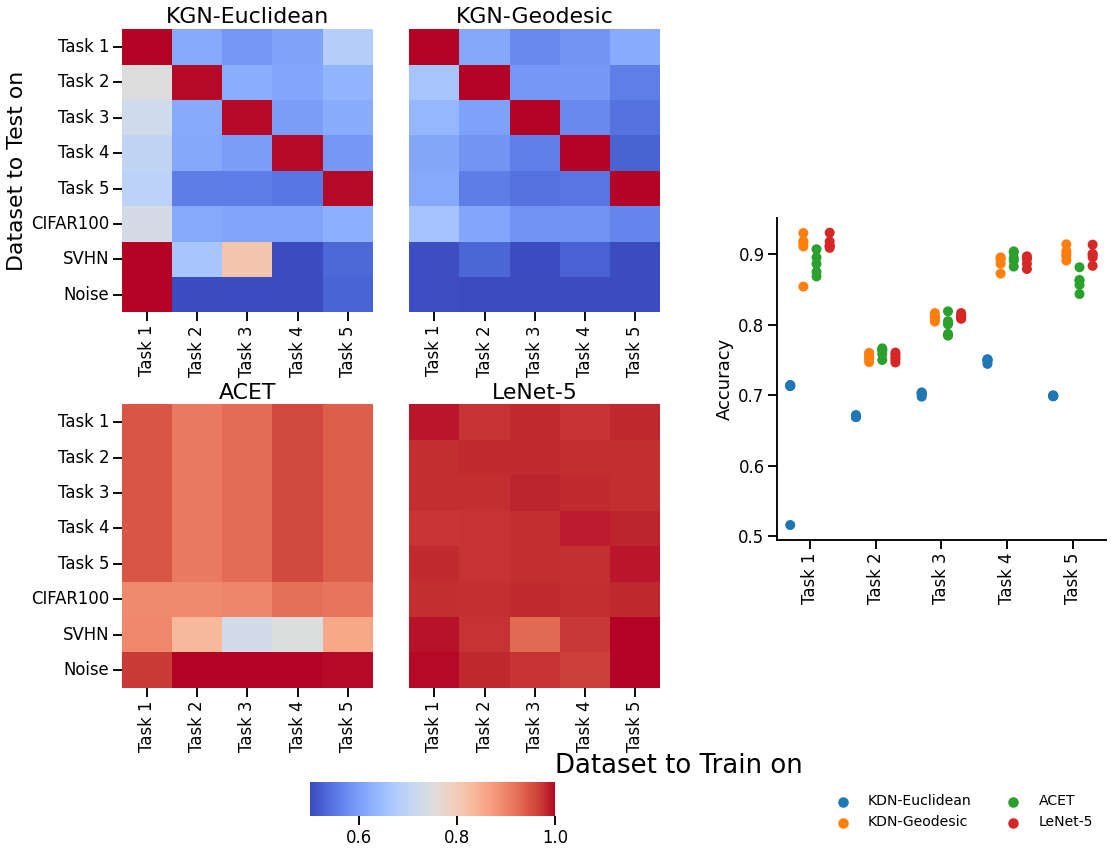

In [58]:
sns.set_context('talk')
fontsize=22
legend_level = .1
fig = plt.figure(constrained_layout=True,figsize=(17,12))
gs = fig.add_gridspec(12,17)

cbar_ax = fig.add_axes([.25, legend_level-.04, .2, .04])

ax = fig.add_subplot(gs[:5,:4])
ax_ = sns.heatmap(kdn_euclidean_df, yticklabels=datasets,\
            vmin=0.5, vmax=1, cbar=None,\
            cmap='coolwarm', ax=ax)
ax.set_title('KGN-Euclidean', fontsize=fontsize)
ax.set_ylabel('Dataset to Test on', fontsize=fontsize)
for item in ax_.get_xticklabels():
    item.set_rotation(90)
    
ax = fig.add_subplot(gs[:5,4:8])
sns.heatmap(kdn_df, yticklabels=datasets,\
            vmin=0.5, vmax=1, cbar=None,\
            cmap='coolwarm', ax=ax)
ax.set_title('KGN-Geodesic', fontsize=fontsize)
ax.set_yticks([])

ax = fig.add_subplot(gs[5:10,:4])
sns.heatmap(benchmark_df, yticklabels=datasets,\
            vmin=0.5, vmax=1,\
            cmap='coolwarm', ax=ax, cbar_ax= cbar_ax, cbar_kws = dict(use_gridspec=True, orientation = 'horizontal'))
ax.set_title('ACET', fontsize=fontsize)
for item in ax.get_xticklabels():
    item.set_rotation(90)
#ax.set_yticks([])

ax = fig.add_subplot(gs[5:10,4:8])
sns.heatmap(dn_df, yticklabels=datasets,\
            vmin=0.5, vmax=1,\
            cmap='coolwarm', ax=ax, cbar_ax= cbar_ax, cbar_kws = dict(use_gridspec=True, orientation = 'horizontal'))
ax.set_title('LeNet-5', fontsize=fontsize)
ax.set_yticks([])

ax = fig.add_subplot(gs[2:8,11:17])
ax_ = sns.stripplot(data=accuracy_df, x='Dataset to Train on', y='Accuracy', hue='Algorithm', jitter=0, size = 10, dodge=True, ax=ax)
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
ax.set_xlabel('')
ax.set_xticks(ax.get_xticks(), rotation=90)
for item in ax_.get_xticklabels():
    item.set_rotation(90)
ax_.legend (fontsize=14, bbox_transform=plt.gcf().transFigure,
                        ncol=2, bbox_to_anchor = (.9, legend_level), frameon=False)

#fig.tight_layout()
fig.text(.45,legend_level+.01,'Dataset to Train on', fontsize=fontsize+4)
plt.savefig('cifar10.pdf')